In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
from time import sleep
import time

import os
import sys
import h5py
import numpy as np
from scipy import signal
from scipy.ndimage.filters import gaussian_filter
import glob

import cv2
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
main = '/content/drive/My Drive/Colab Notebooks/CV_notebooks/project/'
names = ['fall-01-cam0-rgb', 'fall-06-cam0-rgb', 'fall-15-cam0-rgb', 'fall-27-cam0-rgb']
for name in names:
  print('Processing video ', name)
  frames = []
  for i in sorted(glob.glob(main + 'data/' + name + '/*.png')):
    img = cv2.imread(i, 0)
    frames.append(img)
  frames = np.array(frames)

  height, width = frames.shape[1], frames.shape[2]
  u_list = np.zeros((frames.shape[0], height, width))
  v_list = np.zeros((frames.shape[0], height, width))

  # calculate OF with opencv
  for ff in range(1, frames.shape[0]):
    prvs = frames[ff-1] # - frames[ff-1].mean()
    next = frames[ff] # -  frames[ff].mean()
    # add filtering
    # prvs = gaussian_filter(prvs, 1.5)
    # next = gaussian_filter(next, 1.5)
    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 25, 3, 5, 1.2, 0) # window 15
    u_list[ff, :, :] = flow[:,:,0]
    v_list[ff, :, :] = flow[:,:,1]

  # save 
  save_path = os.path.join(main, 'opticalFlow', 'nomean')
  os.makedirs(save_path, exist_ok=True)
  hf = h5py.File(save_path + '/' + name + '.h5', 'w')
  hf.create_dataset('u', data=u_list)
  hf.create_dataset('v', data=v_list)
  hf.close()


Processing video  fall-01-cam0-rgb
Processing video  fall-06-cam0-rgb
Processing video  fall-15-cam0-rgb
Processing video  fall-27-cam0-rgb


In [ ]:
# for our own videos
gif = cv2.VideoCapture(main + '/data/IMG_1002.MOV')

##
num_frames = int(gif.get(cv2.CAP_PROP_FRAME_COUNT))
height = int(gif.get(cv2.CAP_PROP_FRAME_HEIGHT)*0.3)
width = int(gif.get(cv2.CAP_PROP_FRAME_WIDTH)*0.3)
frames = np.zeros((num_frames, height, width))
for i in range(num_frames):
  ret, frame = gif.read()
  frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  img = frame_gray
  scale_percent = 30 # percent of original size
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  dim = (width, height)
  # resize image
  resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  frames[i] = resized

height, width = frames.shape[1], frames.shape[2]
u_list = np.zeros((frames.shape[0], height, width))
v_list = np.zeros((frames.shape[0], height, width))

# calculate OF with opencv
for ff in range(1, frames.shape[0]):
  prvs = frames[ff-1] # - frames[ff-1].mean()
  next = frames[ff] # - frames[ff].mean()
  # add filtering
  # prvs = gaussian_filter(prvs, 1.5)
  # next = gaussian_filter(next, 1.5)
  flow = cv2.calcOpticalFlowFarneback(prvs, next, None, 0.5, 3, 25, 3, 5, 1.2, 0) # window 15
  u_list[ff, :, :] = flow[:,:,0]
  v_list[ff, :, :] = flow[:,:,1]

# save 
save_path = os.path.join(main, 'opticalFlow')
os.makedirs(save_path, exist_ok=True)
hf = h5py.File(save_path + '/' + 'maia.h5', 'w')
hf.create_dataset('u', data=u_list)
hf.create_dataset('v', data=v_list)
hf.close()

In [ ]:
# load OF
import h5py
name = 'fall-27-cam0-rgb'
hf = h5py.File(main + 'opticalFlow/nomean/' + name + '.h5', 'r')
# hf = h5py.File(main + 'opticalFlow/maia.h5', 'r')
u = hf.get('u')
u = np.array(u)

v = hf.get('v')
v = np.array(v)
hf.close()

# define magnitude and orientation
mag = u ** 2 + v ** 2
orient  = np.arctan2(v, u) * 180/np.pi
orient[orient < 0] += 360


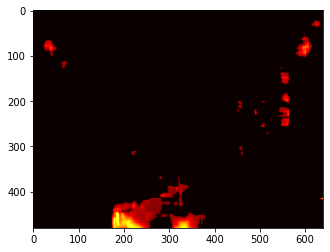

In [ ]:
# visualize magnitude
for i in range(1, u.shape[0]):
# for i in range(111,117):
  clear_output(wait=True)

  # Display the image here
  plt.imshow(mag[i], cmap='hot')
  
  plt.show()
  sleep(0.2)

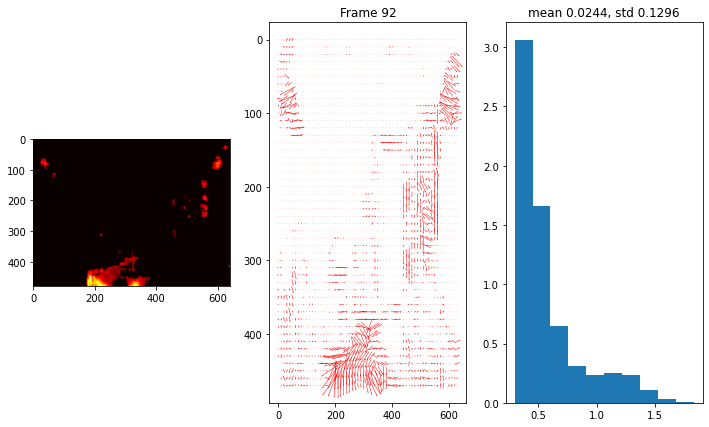

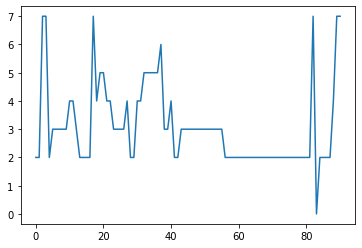

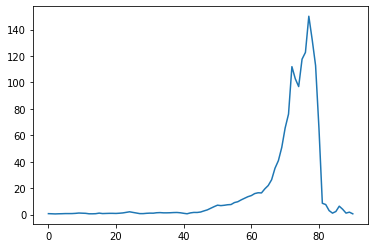

In [ ]:
# quiver plot
bins = []
means = []
width = u.shape[2]
height = u.shape[1]
for i in range(1, u.shape[0]):
# for i in range(159,160):
  clear_output(wait=True)
  x = np.arange(0, width, 1)
  y = np.arange(0, height, 1)
  x, y = np.meshgrid(x, y)
  step = 10
  plt.figure(figsize=(12,7))
  plt.subplot(131)
  # filter by magnitude
  mag[mag<0.3] = 0
  plt.imshow(mag[i], cmap='hot')
  plt.subplot(132)
  plt.quiver(x[::step, ::step], y[::step, ::step],
                u[i][::step, ::step], v[i][::step, ::step],
                color='r', pivot='middle', headwidth=2, headlength=3)

  hh, bb = np.histogram(orient[i].ravel(), bins=10, weights=mag[i].ravel(), density=True)
  bins.append(hh.argmax())

  plt.gca().invert_yaxis()
  plt.title('Frame {}'.format(i + 1))
  plt.subplot(133)
  # plt.hist(orient[i].ravel(), bins=10, weights=mag[i].ravel(), density=True)
  # title = 'mean {}, std {}'.format(np.round(orient[i].mean(), 4), np.round(orient[i].std(), 4))
  # plt.xticks(np.arange(0, 360, step=50))
  filt_mag = mag[i][mag[i]>=0.3]
  means.append(filt_mag.mean())
  plt.hist(filt_mag.ravel(), bins=10, density=True)
  title = 'mean {}, std {}'.format(np.round(mag[i].mean(), 4), np.round(mag[i].std(), 4))
  plt.title(title)
  # plt.hist(mag[i].ravel(), bins=10, density=True)
  plt.show()
  sleep(0.3)

plt.plot(range(len(bins)), bins)
plt.show()
plt.plot(range(len(means)), means)
plt.show()

Text(0, 0.5, 'Average OF magnitude')

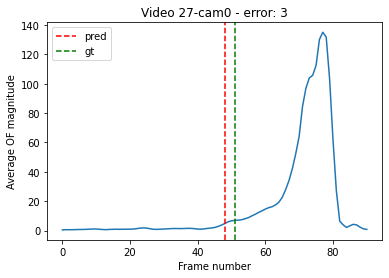

In [ ]:
mm = np.array(means)
N = 3 # depends on number of frames
g = np.convolve(mm, np.ones(N)/N, 'same')

pred = np.where(np.diff(g)>1)[0][0] + 1
# gt = 100 - 60
gt=51
plt.plot(g)

plt.axvline(pred, color='r', linestyle='dashed', label='pred')
plt.axvline(gt, color='g', linestyle='dashed', label='gt')
plt.title('Video 27-cam0 - error: {}'.format(np.round(abs(gt-pred), 4)))
# plt.title('Own video - error: {}'.format(np.round(abs(gt-pred), 4)))
plt.xlabel('Frame number')
plt.legend()
plt.ylabel('Average OF magnitude')

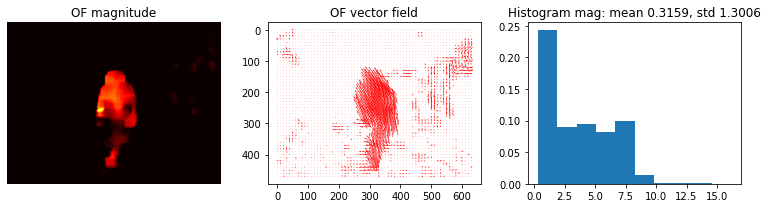

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 3))

pp = pred
# fig.suptitle('Frame {}'.format(pp))
# plt.subplot(131)
# filter by magnitude
mag[mag<0.3] = 0
ax1.imshow(mag[pp], cmap='hot', aspect='auto')
ax1.set_title('OF magnitude')
ax1.axis('off')
# plt.subplot(132)
ax2.quiver(x[::step, ::step], y[::step, ::step],
           u[pp][::step, ::step], v[pp][::step, ::step],
           color='r', pivot='middle', headwidth=2, headlength=3)
ax2.invert_yaxis()
ax2.set_title('OF vector field')
# plt.subplot(133)
filt_mag = mag[pp][mag[pp]>=0.3]
means.append(filt_mag.mean())
ax3.hist(filt_mag.ravel(), bins=10, density=True)
title = 'Histogram mag: mean {}, std {}'.format(np.round(mag[pp].mean(), 4), np.round(mag[pp].std(), 4))
ax3.set_title(title)
fig.tight_layout()